<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/ModulAAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://drive.google.com/uc?export=view&id=1kru4zycIAmt9hF65rKPrcgVY-61GBuS6' width=700px align=centre>


In [ ]:
#@title  Packages and Globlal Variables
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import gspread
import random
from scipy.optimize import differential_evolution
import logging
from typing import List, Dict, Tuple
import configparser
import argparse

#from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution
#from scipy.interpolate import interp1d


# Precomputed activation energies in kJ/mol (converted to J/mol)
activation_energies = {
    'Asx_ConcTHAA': 111.09 * 1000,
    'Asx_ConcFAA': 98.93 * 1000, 'Asx_DLTHAA': 126.02 * 1000, 'Asx_DLFAA': 121.99 * 1000, 'Glx_ConcTHAA': 105.46 * 1000, 'Glx_ConcFAA': 109.39 * 1000, 'Glx_DLTHAA': 121.89 * 1000,
    'Glx_DLFAA': 100.80 * 1000, 'Ser_ConcTHAA': 127.59 * 1000, 'Ser_ConcFAA': 97.95 * 1000, 'Ser_DLTHAA': 123.03 * 1000, 'Ser_DLFAA': 116.72 * 1000, 'Ala_ConcTHAA': 96.58 * 1000,
    'Ala_ConcFAA': 112.12 * 1000, 'Ala_DLTHAA': 113.58 * 1000, 'Ala_DLFAA': 98.88 * 1000, 'Val_ConcTHAA': 111.00 * 1000, 'Val_ConcFAA': 122.81 * 1000,
    'Val_DLTHAA': 99.73 * 1000, 'Val_DLFAA': 128.52 * 1000, 'Phe_ConcTHAA': 113.28 * 1000, 'Phe_ConcFAA': 98.88 * 1000, 'Phe_DLTHAA': 128.15 * 1000, 'Phe_DLFAA': 102.27 * 1000, 'Leu_ConcTHAA': 114.09 * 1000,
    'Leu_ConcFAA': 103.75 * 1000, 'Leu_DLTHAA': 105.43 * 1000, 'Leu_DLFAA': 105.43 * 1000, 'Ile_ConcTHAA': 114.09 * 1000, 'Ile_ConcFAA': 103.75 * 1000, 'Ile_DLTHAA': 105.43 * 1000, 'Ile_DLFAA': 105.43 * 1000
}

# Define the mapping from one-letter to three-letter amino acid codes
one_to_three_letter = {
    "I": "Ile", "V": "Val", "L": "Leu", "F": "Phe", "C": "Cys", "M": "Met",
    "A": "Ala", "G": "Gly", "T": "Thr", "W": "Trp", "S": "Ser", "Y": "Tyr",
    "P": "Pro", "H": "His", "Q": "Gln", "E": "Glx", "N": "Asn", "D": "Asx",
    "K": "Lys", "R": "Arg", "D": "Asx", "E": "Glx"
}

# Pre-exponential factors for each type of rate (example values)
pre_exponential_factors = {
    'Asx': {'internal': 1e19, 'terminal': 1e20, 'free': 1e18, 'loss': 1e18},
    'Glx': {'internal': 1e17, 'terminal': 1e20, 'free': 1e17, 'loss': 1e16},
    'Ser': {'internal': 1e19, 'terminal': 1e20, 'free': 1e20, 'loss': 1e15},
    'Ala': {'internal': 1e17, 'terminal': 1e17, 'free': 1e16, 'loss': 1e20},
    'Val': {'internal': 1e17, 'terminal': 1e20, 'free': 1e15, 'loss': 1e10},
    'Phe': {'internal': 1e17, 'terminal': 1e17, 'free': 1e20, 'loss': 1e15},
    'Leu': {'internal': 1e19, 'terminal': 1e18, 'free': 1e13, 'loss': 1e20},
    'Ile': {'internal': 1e16, 'terminal': 1e20, 'free': 1e18, 'loss': 1e20}
}

# Define a mapping from rate type descriptions to pre-exponential factor keys
rate_type_mapping = {
    'ConcTHAA': 'internal',
    'ConcFAA': 'terminal',
    'DLTHAA': 'free',
    'DLFAA': 'loss'
}


# Function to calculate the rate constant using the Arrhenius equation with pre-exponential
# Universal gas constant in J/(mol·K)
R = 8.314

def arrhenius_rate_constant(E_a, T, A):
    return A * np.exp(-E_a / (R * T))


In [ ]:
# Set up logging to file
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='/content/drive/MyDrive/Colab_Notebooks/AAR_Model/Fitting/Debugging/simulate_amino_acid_hydrolysis.log',  # Specify your log filename
                    filemode='a')  # 'w' for overwrite, 'a' for append

# Create logger
logger = logging.getLogger()

# Test logging
logger.info("This is a test log message.")

In [ ]:
#@title Colours
# Load color dictionary
color_dict_path = '/content/drive/MyDrive/Colab_Notebooks/Dictionaries/Colours/colors.json'
with open(color_dict_path, 'r') as file:
    color_dict = json.load(file)


# Amino acid colors
amino_acid_colors = color_dict["amino_acids_colors"]
one_to_three_letter = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln',
                       'G': 'Gly', 'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe',
                       'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}


# Create a dictionary mapping three-letter codes to concentration column names
three_letter_to_Conc = {
    'Ala': '[Ala]', 'Arg': '[Arg]', 'Asn': '[Asx]', 'Asp': '[Asx]', 'Cys': '[Cys]',
    'Glu': '[Glx]', 'Gln': '[Glx]', 'Gly': '[Gly]', 'His': '[His]', 'Ile': '[Ile]',
    'Leu': '[Leu]', 'Lys': '[Lys]', 'Met': '[Met]', 'Phe': '[Phe]', 'Pro': '[Pro]',
    'Ser': '[Ser]', 'Thr': '[Thr]', 'Trp': '[Trp]', 'Tyr': '[Tyr]', 'Val': '[Val]'
}

# Create a color dictionary for three-letter codes
amino_acid_colors_three_letter = {one_to_three_letter[k]: v for k, v in amino_acid_colors.items() if k in one_to_three_letter}

# Create the final color dictionary for concentration column names
amino_acid_colors_conc = {three_letter_to_Conc[k]: v for k, v in amino_acid_colors_three_letter.items() if k in three_letter_to_Conc}


# Function to adjust color saturation
def adjust_saturation(color, amount=0.5):
    color = mcolors.to_rgba(color)
    color = mcolors.rgb_to_hsv(color[:3])
    color[1] = max(0, min(1, color[1] * amount))
    return mcolors.hsv_to_rgb(color)

# Adjust colors for standard deviations
std_colors = {k: adjust_saturation(v, 0.5) for k, v in amino_acid_colors_three_letter.items()}


In [ ]:
#@title Functions to select the amino acid and build the dataframe

def prepare_and_filter_data(df, amino_acid, temperature_kelvin):
    """
    Prepare and filter the DataFrame for a specific amino acid at a specified temperature in Kelvin.

    Args:
        df (DataFrame): The DataFrame to filter.
        amino_acid (str): The amino acid code (e.g., 'Asx', 'Val').
        temperature_kelvin (float): The temperature in Kelvin.

    Returns:
        DataFrame: A DataFrame prepared and filtered for hydrolysis simulation.
    """
    # Define relevant suffixes the simulation function uses
    relevant_suffixes = ['Mean', 'Std', 'DL_Mean', 'DL_Std']  # Add or remove as per actual usage in simulation

    # Filter for the specified amino acid at the given temperature in Kelvin
    # and only include columns with relevant suffixes
    relevant_columns = [
        col for col in df.columns
        if amino_acid in col and any(suffix in col for suffix in relevant_suffixes)
    ]
    relevant_columns.extend(['time', 'temp (K)'])  # Ensure time and temperature columns are included

    # Apply filtering for temperature and select relevant columns
    filtered_data = df[
        (df['temp (K)'] == temperature_kelvin)
    ][relevant_columns]

    # Keep amino acid prefixes in column names (skip renaming)
    # filtered_data.columns = [col.replace(f'{amino_acid}_', '') for col in filtered_data.columns]

    return filtered_data

def prepare_and_categorize_data(df: pd.DataFrame, temperature_kelvin: float) -> Dict[str, pd.DataFrame]:
    """
    Prepare and categorize the DataFrame for simulation.

    Args:
        df (pd.DataFrame): The DataFrame containing amino acid data.
        temperature_kelvin (float): The temperature in Kelvin.

    Returns:
        Dict[str, pd.DataFrame]: A dictionary containing filtered and categorized data for each group.
    """
    # Check if 'temp (K)' column exists, and handle the case if it doesn't
    if 'temp (K)' not in df.columns:
        # Try to find a column that represents temperature and convert it to Kelvin
        if 'temp (°C)' in df.columns:
            df['temp (K)'] = df['temp (°C)' ] + 273.15 # Convert Celsius to Kelvin
            print("Warning: 'temp (K)' column not found. Converted 'temp (°C)' to Kelvin.")
        else:
            raise ValueError("Neither 'temp (K)' nor 'temp (°C)' column found in DataFrame.")

    # Define the amino acid groups
    categories = {
        'THAA_dehyd': ['Serine', 'Threonine'],
        'THAA_cyclic': ['Glx'],
        'THAA_no_water': []
    }

    # Categorize all other amino acids into 'THAA_no_water'
    for col in df.columns:
        amino_acid = col.split('_')[0]  # Assuming column names are like 'Serine_Conc', 'GLX_Conc', etc.
        if amino_acid not in categories['THAA_dehyd'] and amino_acid not in categories['THAA_cyclic']:
            categories['THAA_no_water'].append(amino_acid)

    # Prepare filtered data for each category
    filtered_data = {}
    for category, amino_acids in categories.items():
        relevant_columns = ['time', 'temp (K)']
        for aa in amino_acids:
            relevant_columns.extend([col for col in df.columns if aa in col])

        # Filter data for the specified temperature
        filtered_data[category] = df[(df['temp (K)'] == temperature_kelvin)][relevant_columns]

    return filtered_data


# Function to filter and clean data
def clean_data(df):
    # Convert concentration and D/L columns to numeric, coerce errors to NaN
    concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
    dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

    for col in concentration_columns + dl_columns:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Filter out rows with comments or non-numeric entries in critical columns
    df = df.dropna(subset=concentration_columns + dl_columns)

    return df

cleaned_data = clean_data(data)

# Function to calculate means and standard deviations separately for FAA and THAA, including time
def calculate_stats(df):
    faa_df = df[df['sample'] == 'FAA']
    thaa_df = df[df['sample'] == 'THAA']

    grouped_faa = faa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    grouped_thaa = thaa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    # Rename columns to reflect FAA and THAA
    new_columns_faa = ['temp (°C)', 'time'] + [f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                      [f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
    new_columns_thaa = ['temp (°C)', 'time'] + [f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                       [f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

    grouped_faa.columns = new_columns_faa
    grouped_thaa.columns = new_columns_thaa

    # # Handle single values and missing standard deviations
    # for col in new_columns_faa:
    #     if '_Std' in col:
    #         grouped_faa[col] = grouped_faa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)
    # for col in new_columns_thaa:
    #     if '_Std' in col:
    #         grouped_thaa[col] = grouped_thaa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)

    # Vectorized handling of single values in standard deviations for FAA
    for col in new_columns_faa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

    # Vectorized handling for THAA
    for col in new_columns_thaa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

    return grouped_faa, grouped_thaa


def clean_data(df):
    # Convert concentration and D/L columns to numeric, coerce errors to NaN
    concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
    dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

    for col in concentration_columns + dl_columns:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Filter out rows with comments or non-numeric entries in critical columns
    df = df.dropna(subset=concentration_columns + dl_columns)

    return df

# Function to calculate means and standard deviations separately for FAA and THAA, including time
def calculate_stats(df):
    faa_df = df[df['sample'] == 'FAA']
    thaa_df = df[df['sample'] == 'THAA']

    grouped_faa = faa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    grouped_thaa = thaa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    # Rename columns to reflect FAA and THAA
    new_columns_faa = ['temp (°C)', 'time'] + [f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                      [f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
    new_columns_thaa = ['temp (°C)', 'time'] + [f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                       [f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

    grouped_faa.columns = new_columns_faa
    grouped_thaa.columns = new_columns_thaa

    # # Handle single values and missing standard deviations
    # for col in new_columns_faa:
    #     if '_Std' in col:
    #         grouped_faa[col] = grouped_faa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)
    # for col in new_columns_thaa:
    #     if '_Std' in col:
    #         grouped_thaa[col] = grouped_thaa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)

    # Vectorized handling of single values in standard deviations for FAA
    for col in new_columns_faa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

    # Vectorized handling for THAA
    for col in new_columns_thaa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

    return grouped_faa, grouped_thaa


def calculate_amino_acid_distribution_with_loss(df, amino_acid):
    amino_acid_distributions = []

    initial_thaa = df[f"{amino_acid}_Conc_THAA_Mean"].iloc[0]

    for index, row in df.iterrows():
        thaa = row[f"{amino_acid}_Conc_THAA_Mean"]
        faa = row[f"{amino_acid}_Conc_FAA_Mean"]
        thaa_dl = row[f"{amino_acid}_D/L_THAA_Mean"]
        faa_dl = row[f"{amino_acid}_D/L_FAA_Mean"]
        time_point = row["time"]

        # Calculate BAA
        baa = thaa - faa
        baa_d = baa * thaa_dl / (1 + thaa_dl)
        baa_l = baa - baa_d

        # Calculate FAA
        faa_d = faa * faa_dl / (1 + faa_dl)
        faa_l = faa - faa_d

        # Calculate total loss
        total_loss = max(initial_thaa - thaa, 0)

        # Distribute total loss between D and L forms based on current FAA D/L ratio
        if total_loss > 0:
            loss_d = total_loss * faa_dl / (1 + faa_dl)
            loss_l = total_loss - loss_d
        else:
            loss_d = 0
            loss_l = 0

        # Calculate standard deviations
        thaa_std = row[f"{amino_acid}_Conc_THAA_Std"] if f"{amino_acid}_Conc_THAA_Std" in df.columns else 0
        faa_std = row[f"{amino_acid}_Conc_FAA_Std"] if f"{amino_acid}_Conc_FAA_Std" in df.columns else 0

        baa_std = np.sqrt(thaa_std**2 + faa_std**2)
        baa_d_std = baa_std * thaa_dl / (1 + thaa_dl)
        baa_l_std = baa_std - baa_d_std

        faa_d_std = faa_std * faa_dl / (1 + faa_dl)
        faa_l_std = faa_std - faa_d_std

        loss_std = np.sqrt(2 * thaa_std**2)  # Using THAA std for loss calculation
        loss_d_std = loss_std * faa_dl / (1 + faa_dl)
        loss_l_std = loss_std - loss_d_std

        amino_acid_distribution = {
            "time": time_point,
            "temp (K)": row["temp (K)"],
            "BAA_D": baa_d,
            "BAA_L": baa_l,
            "BAA_D_Std": baa_d_std,
            "BAA_L_Std": baa_l_std,
            "FAA_D": faa_d,
            "FAA_L": faa_l,
            "FAA_D_Std": faa_d_std,
            "FAA_L_Std": faa_l_std,
            "FAA_D_loss": loss_d,
            "FAA_L_loss": loss_l,
            "FAA_D_loss_Std": loss_d_std,
            "FAA_L_loss_Std": loss_l_std,
        }

        amino_acid_distributions.append(amino_acid_distribution)

    return pd.DataFrame(amino_acid_distributions)

In [ ]:
NUM_TIME_POINTS = 10  # Example value; adjust as necessary
amino_acid = 'Asx'
initial_length = 150  # Assuming protein length is constant
temperature_kelvin = 383.15  # Example temperature

In [ ]:
#@title Load Data





# URLs and GIDs for Google Sheets
sheet_id = "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E"
gid = "1259514505"
export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
try:
  df = pd.read_csv(export_url)
  print("Data successfully loaded into DataFrame!")
except Exception as e:
  print(f"Error: Could not access data. {e}")

# Ensure the columns match your Google Sheets structure
expected_columns = [
    'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time',
    '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
    'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
]
# 3. Rename the column (assuming extracted time or existing time format)
df = df.rename(columns={'time (h)': 'time'})


# Ensure all expected columns are present in the data
data = df[expected_columns]

# # Initial Data Check
# print("Initial Data:")
# print(data.head())
# Add the 'temp (K)' column using a lambda function for efficiency
data['temp (K)'] = data['temp (°C)'] + 273.15

# Handle potential errors (e.g., missing 'temp (°C)' column)
if 'temp (°C)' not in data.columns:
    print("Warning: 'temp (°C)' column not found in the DataFrame.")
    # Optionally, fill with a placeholder value (adjust as needed)
    df['temp (K)'] = pd.NA


# Filter and clean data
cleaned_data = clean_data(data)

print("cleaned_data:--------------------------")
print(cleaned_data.head(5))
# Calculate statistics
faa_stats, thaa_stats = calculate_stats(cleaned_data)

# Merge FAA and THAA statistics
data_interpolated = pd.merge(faa_stats, thaa_stats, on=['temp (°C)', 'time'], how='outer')

# Add 'temp (K)' column to the merged DataFrame
data_interpolated['temp (K)'] = data_interpolated['temp (°C)'] + 273.15

# # Initial Data Check after Cleaning and Interpolation
# print("Cleaned and Interpolated Data:")
# print(data_interpolated.head())
# headers=data_interpolated.columns.tolist()
# #print(headers)  # Original headers

#calculate BAA
real_data = prepare_and_filter_data(data_interpolated, amino_acid, temperature_kelvin)

print("real_data:--------------------------")

print(real_data.head(10))


# Check prepared data
real_DL = calculate_amino_acid_distribution_with_loss(real_data, amino_acid)

# Print the DataFrame
print(" ")
print("real_DL:--------------------------")
print(real_DL.head(5))


Data successfully loaded into DataFrame!
cleaned_data:--------------------------
   Pre-heat bleach time (h)  temp (°C)  pH sample  time  [Asx] [Glx]  [Ser]  \
0                        72         80   7    FAA   0.0   36.0  21.0  190.0   
1                        72         80   7    FAA   0.0   42.0  25.0  157.0   
2                        72         80   7    FAA   0.0   52.0  31.0  151.0   
4                        72        110   7    FAA   0.0  116.0  85.0  115.0   
5                        72        110   7    FAA   0.0  260.0  55.0   78.0   

   [Ala] [Val] [Phe] [Ile] Asx D/L  Glx D/L  Ser D/L  Ala D/L  Val D/L  \
0  111.0  19.0  29.0  18.0    0.21     0.00     0.11     0.07      0.0   
1   97.0  15.0  29.0  16.0     0.0     0.00     0.13     0.00      0.0   
2  102.0  16.0  27.0  16.0     0.1     0.00     0.11     0.05      0.0   
4   62.0  12.0  22.0  18.0    0.08     0.09     0.24     0.09      0.0   
5   45.0   7.0  18.0  14.0    0.02     0.06     0.22     0.11      0.0   


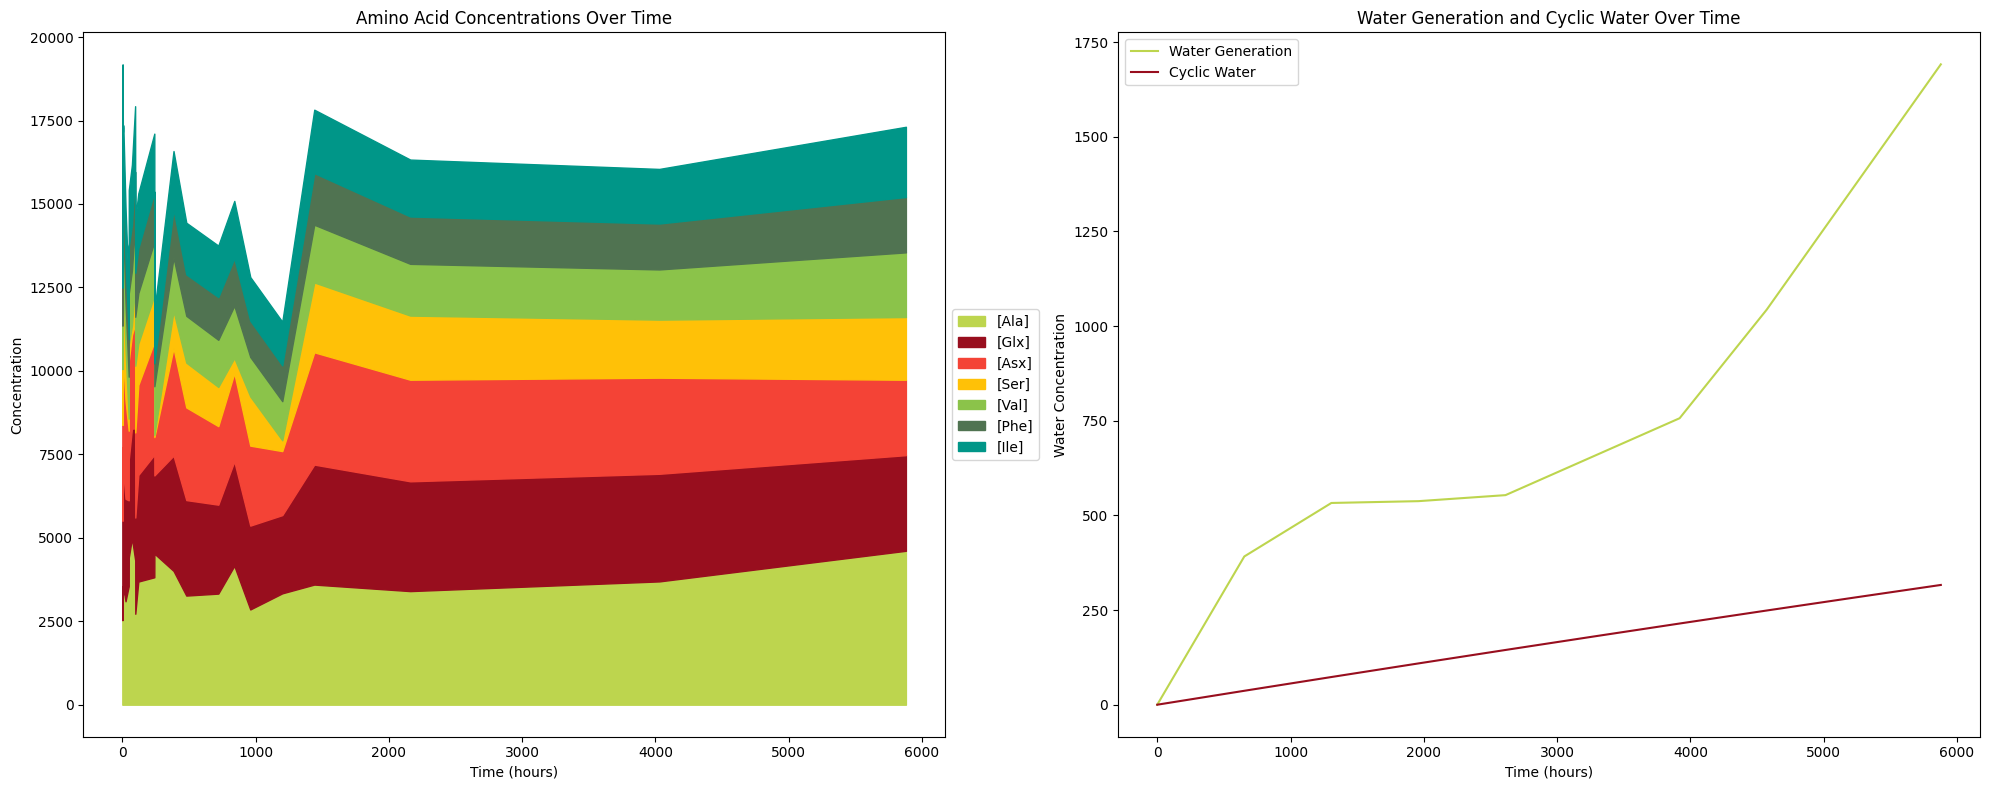

In [ ]:
#@title  Calculate water generation
def categorize_amino_acids(df):
    concentration_columns = [col for col in df.columns if col.startswith('[') and col.endswith(']')]
    categories = {
        'THAA_dehyd': ['[Ala]'],
        'THAA_cyclic': ['[Glx]'],
        'THAA_no_water': [col for col in concentration_columns if col not in ['[Ala]', '[Glx]']]
    }
    return categories

def initialize_concentrations(df, categories):
    concentrations = {}

    for category, amino_acids in categories.items():
        category_dict = {}
        for aa in amino_acids:
            category_dict[aa] = df.groupby('time')[aa].mean()
        concentrations[category] = category_dict

    return concentrations

def exponential_decay(t, A, k):
    return A * np.exp(-k * t)

def estimate_rate_params(concentrations, categories, cleaned_data):
    rate_params = {}
    for category, aa_list in categories.items():
        for aa in aa_list:
            time = cleaned_data['time'].unique()
            conc = concentrations[category][aa]
            try:
                popt, _ = curve_fit(exponential_decay, time, conc, p0=[conc[0], 0.001], maxfev=10000)
                rate_params[aa.lower()] = popt[1]
                if category == 'THAA_cyclic':
                    rate_params[f'{aa.lower()}_equilibrium'] = popt[1]
            except RuntimeError as e:
                print(f"Could not estimate rate for {aa}: {str(e)}")
                rate_params[aa.lower()] = 0.001  # default value
                if category == 'THAA_cyclic':
                    rate_params[f'{aa.lower()}_equilibrium'] = 0.001
    return rate_params

def calculate_water_generation(concentrations, time_points, categories):
    water_generation = np.zeros(len(time_points))

    for aa in categories['THAA_dehyd']:
        # initial_concentration = concentrations['THAA_dehyd'][aa][0]
        # # Use interpolation to align concentration values with time_points
        # concentration_values = np.interp(time_points, concentrations['THAA_dehyd'][aa].index, concentrations['THAA_dehyd'][aa].values)
        initial_concentration = concentrations['THAA_dehyd'][aa][0]
        # Ensure time and concentration values are numeric
        time_values = concentrations['THAA_dehyd'][aa].index.astype(float)
        concentration_values = concentrations['THAA_dehyd'][aa].values.astype(float)
        # Use interpolation to align concentration values with time_points
        concentration_values = np.interp(time_points, time_values, concentration_values)
        for i, t in enumerate(time_points):
            current_concentration = concentration_values[i] # Directly use the interpolated value
            water_generation[i] += max(current_concentration - initial_concentration, 0)

    return water_generation

def calculate_cyclic_water(concentrations, rate_params, time_points, categories):
    cyclic_water = np.zeros(len(time_points))

    for i, t in enumerate(time_points):
        for aa in categories['THAA_cyclic']:
            equilibrium_rate = rate_params[f'{aa.lower()}_equilibrium']
            initial_concentration = concentrations['THAA_cyclic'][aa][0]
            concentration = initial_concentration * np.exp(-equilibrium_rate * t)
            cyclic_water[i] = initial_concentration - concentration

    return cyclic_water


NUM_TIME_POINTS = 10  # Number of points for interpolation

# Categorize amino acids
categories = categorize_amino_acids(cleaned_data)

# Initialize concentrations
concentrations = initialize_concentrations(cleaned_data, categories)

# Estimate rate parameters (only needed for cyclic water now)
rate_params = estimate_rate_params(concentrations, categories, cleaned_data)

# Create interpolated time points
time_points = np.linspace(cleaned_data['time'].min(), cleaned_data['time'].max(), NUM_TIME_POINTS)

# Calculate water generation and cyclic water
water_generation = calculate_water_generation(concentrations, time_points, categories)
cyclic_water = calculate_cyclic_water(concentrations, rate_params, time_points, categories)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Stacked area plot for amino acid concentrations
unique_times = cleaned_data['time'].unique()
bottom = np.zeros(len(unique_times))

for category in categories.values():
    for aa in category:
        category_key = list(categories.keys())[list(categories.values()).index(category)]
        concentration_series = concentrations[category_key][aa]

        # Reindex the concentration series to match all unique time points
        concentration = concentration_series.reindex(unique_times, method='ffill').fillna(0).values

        # Use the color from amino_acid_colors_conc if available, otherwise use a default color
        color = amino_acid_colors_conc.get(aa, 'gray')

        ax1.fill_between(unique_times, bottom, bottom + concentration, label=aa, color=color)
        bottom += concentration

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Concentration')
ax1.set_title('Amino Acid Concentrations Over Time')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Line plots for water generation and cyclic water
ala_color = amino_acid_colors_conc.get('[Ala]', 'blue')
glx_color = amino_acid_colors_conc.get('[Glx]', 'red')

ax2.plot(time_points, water_generation, label='Water Generation', color=ala_color)
ax2.plot(time_points, cyclic_water, label='Cyclic Water', color=glx_color)
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Water Concentration')
ax2.set_title('Water Generation and Cyclic Water Over Time')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
#@title ##Simulation Functions

def solve_dl(ratio, sum_value):
    """Calculate D and L concentrations given a D/L ratio and their sum."""
    L = sum_value / (1 + ratio)
    D = ratio * L
    return D, L

def update_dl_ratio(D, L, rate, slow_pool_size, slow_pool_relative_rate):
    """Update the D and L values based on decay rate and pool dynamics."""
    fast_pool_size = 1 - slow_pool_size
    rate_fast = rate
    rate_slow = rate * slow_pool_relative_rate
    effective_rate = rate_fast * fast_pool_size + rate_slow * slow_pool_size
    D_new = D + (L * effective_rate) - (D * effective_rate)
    L_new = L - (L * effective_rate) + (D * effective_rate)
    return D_new, L_new

def check_racemization(simulated_data, step):
    dl_ratio_term = simulated_data['D_term'][step] / simulated_data['L_term'][step] if simulated_data['L_term'][step] != 0 else float('inf')
    dl_ratio_free = simulated_data['D_free'][step] / simulated_data['L_free'][step] if simulated_data['L_free'][step] != 0 else float('inf')
    print(f"Step {step}: D/L ratio terminal = {dl_ratio_term:.4f}, D/L ratio free = {dl_ratio_free:.4f}")

def check_internal_terminal_balance(simulated_data, step):
    total_internal = simulated_data['D_int'][step] + simulated_data['L_int'][step]
    total_terminal = simulated_data['D_term'][step] + simulated_data['L_term'][step]
    print(f"Step {step}: Total internal = {total_internal:.2f}, Total terminal = {total_terminal:.2f}")


#-----------------------------------------------------------------

import numpy as np

import numpy as np
from typing import Dict

def initialize_results(time_points: np.ndarray, data: pd.DataFrame, faa_d_col: str, faa_l_col: str,
                       faa_d_loss_col: str, faa_l_loss_col: str, fold_water: float) -> Dict[str, np.ndarray]:
    """
    Initialize the results dictionary with numpy arrays to track the simulation results over time.
    This includes tracking of water molecules which decline as the reaction progresses.

    Args:
        time_points (np.ndarray): Array of time points for the simulation.
        data (pd.DataFrame): DataFrame containing initial data points.
        faa_d_col (str): Column name for FAA_D in the data.
        faa_l_col (str): Column name for FAA_L in the data.
        faa_d_loss_col (str): Column name for FAA_D_loss in the data.
        faa_l_loss_col (str): Column name for FAA_L_loss in the data.
        fold_water (float): Multiplier for the initial amount of water relative to THAA.

    Returns:
        Dict[str, np.ndarray]: Dictionary containing initialized result arrays for the simulation.
    """
    results = {
        'time': time_points,
        'BAA_D': np.full_like(time_points, np.nan),
        'BAA_L': np.full_like(time_points, np.nan),
        'FAA_D': np.full_like(time_points, np.nan),
        'FAA_L': np.full_like(time_points, np.nan),
        'TAA_D': np.full_like(time_points, np.nan),
        'TAA_L': np.full_like(time_points, np.nan),
        'FAA_D_loss': np.full_like(time_points, np.nan),
        'FAA_L_loss': np.full_like(time_points, np.nan),
        'THAA': np.full_like(time_points, np.nan),
        'D_int': np.full_like(time_points, np.nan),
        'L_int': np.full_like(time_points, np.nan),
        'D_term': np.full_like(time_points, np.nan),
        'L_term': np.full_like(time_points, np.nan),
        'D_free': np.full_like(time_points, np.nan),
        'L_free': np.full_like(time_points, np.nan),
        'Water_Molecules': np.full_like(time_points, np.nan)  # Initialize water molecule tracking
    }

    # Set initial conditions from data for the first time point only
    results['BAA_D'][0] = data[faa_d_col].iloc[0]
    results['BAA_L'][0] = data[faa_l_col].iloc[0]
    results['FAA_D'][0] = data[faa_d_col].iloc[0]
    results['FAA_L'][0] = data[faa_l_col].iloc[0]
    results['FAA_D_loss'][0] = data[faa_d_loss_col].iloc[0]
    results['FAA_L_loss'][0] = data[faa_l_loss_col].iloc[0]
    results['THAA'][0] = results['BAA_D'][0] + results['BAA_L'][0]  # Initialize THAA correctly as the sum of BAA_D and BAA_L
    results['Water_Molecules'][0] = fold_water * results['THAA'][0]  # Set the initial amount of water molecules based on fold_water multiplier and initial THAA

    return results


# def break_bonds(fragments: List[int], water_molecules: float, rate_params: Dict[str, float],
#                 dt: float) -> Tuple[List[int], int]:
#     new_fragments = []
#     bonds_broken = 0
#     for fragment_length in fragments:
#         num_bonds = fragment_length - 1
#         k_adjusted = calculate_adjusted_rate(rate_params, water_molecules)
#         broken_bonds = np.random.rand(num_bonds) < k_adjusted * dt
#         bonds_broken += np.sum(broken_bonds)
#         new_fragments.extend(split_fragment(fragment_length, broken_bonds))
#     return new_fragments, int(bonds_broken)

# import numpy as np

import numpy as np
from typing import List, Dict, Tuple

def break_bonds(fragments: List[int], water_molecules: float, rate_params: Dict[str, float], dt: float) -> Tuple[List[int], int, float]:
    """
    Simulates bond breaking in fragments based on rate constants, time step, and water availability.

    Args:
        fragments (List[int]): List containing lengths of each fragment.
        water_molecules (float): Number of water molecules present.
        rate_params (Dict[str, float]): Dictionary containing rate constant parameters.
        dt (float): Time step for the simulation.

    Returns:
        Tuple[List[int], int, float]: A tuple containing:
            - List of fragment lengths after breaking bonds.
            - Total number of bonds broken during this time step.
            - Updated count of water molecules after the reaction.
    """
    new_fragments = []
    bonds_broken = 0

    for fragment_length in fragments:
        if fragment_length > 1:  # Check to ensure there are bonds to break
            num_bonds = fragment_length - 1
            k_adjusted = calculate_adjusted_rate(rate_params, water_molecules)
            # Determine the bonds that break in this timestep
            broken_bonds = np.random.rand(num_bonds) < k_adjusted * dt
            bonds_broken_this_fragment = int(np.sum(broken_bonds))

            # Update water molecules based on the number of bonds broken
            water_molecules -= bonds_broken_this_fragment
            bonds_broken += bonds_broken_this_fragment

            # Update fragment lengths based on where bonds broke
            # Optionally log detailed predictions for debugging
            logging.debug({
                "fragment_length": fragment_length,
                "num_bonds": num_bonds,
                "k_adjusted": k_adjusted,
                "broken_bonds": broken_bonds.sum(),
                "remaining_water": water_molecules
            })
        else:
            # If fragment length is 1, no bonds can be broken; add as is
            new_fragments.append(fragment_length)

    return new_fragments, bonds_broken, water_molecules

def calculate_adjusted_rate(rate_params: Dict[str, float], water_molecules: float) -> float:
    """
    Calculate the adjusted rate based on the current number of water molecules and rate parameters.
    This is a placeholder for the actual implementation, which would typically adjust the rate based
    on reaction kinetics and the availability of reactants (like water).

    Args:
        rate_params (Dict[str, float]): Rate parameters for the reaction.
        water_molecules (float): Current count of water molecules.

    Returns:
        float: Adjusted rate constant.
    """
    # Example calculation; replace with actual chemistry-based logic
    k_base = rate_params.get('k_base', 1.0)  # Default to 1.0 if not specified
    return k_base * (water_molecules / (water_molecules + 1000))  # Example of a rate adjustment

def split_fragment(fragment_length: int, broken_bonds: np.ndarray) -> List[int]:
    """
    Given a fragment length and a boolean array indicating which bonds are broken,
    return a list of new fragment lengths.

    Args:
        fragment_length (int): The original length of the fragment.
        broken_bonds (np.ndarray): An array of booleans where True indicates a bond was broken.

    Returns:
        List[int]: List of new fragment lengths resulting from the bond breaks.
    """
    # Determine the indices where bonds are broken
    breaks = np.where(broken_bonds)[0]
    # Calculate the new fragment lengths
    if len(breaks) == 0:
        return [fragment_length]
    else:
        # Include the start and end of the fragment to calculate lengths
        return np.diff([0] + breaks.tolist() + [fragment_length]).tolist()


def update_concentrations(results: Dict[str, np.ndarray], i: int, fragments: List[int],
                          N: int, concentration_d: float, concentration_l: float) -> Dict[str, np.ndarray]:
    total_F = sum(1 for frag in fragments if frag == 1)
    total_T = sum(2 for frag in fragments if frag > 1)
    total_I = sum(frag - 2 for frag in fragments if frag > 2)

    results['FAA_D'][i] = (total_F / N) * concentration_d
    results['FAA_L'][i] = (total_F / N) * concentration_l
    results['BAA_D'][i] = ((total_T + total_I) / N) * concentration_d
    results['BAA_L'][i] = ((total_T + total_I) / N) * concentration_l

    results['TAA_D'][i] = results['BAA_D'][i] + results['FAA_D'][i]
    results['TAA_L'][i] = results['BAA_L'][i] + results['FAA_L'][i]

    return results

def update_dl_ratios(results: Dict[str, np.ndarray], i: int, rate_params: Dict[str, float]) -> Dict[str, np.ndarray]:
    # Placeholder for any additional updates to D/L ratios, as required.
    # Assuming this function is modified based on specific needs.
    return results

def handle_special_cases(results: Dict[str, np.ndarray], i: int, amino_acid: str, num_bonds_broken: int) -> Dict[str, np.ndarray]:
    if amino_acid in ['Ser', 'Thr']:
        # Generate water molecules for Ser and Thr
        results['FAA_D_loss'][i] += num_bonds_broken  # Example, adjust based on specific water generation logic
        results['FAA_L_loss'][i] += num_bonds_broken  # Example, adjust based on specific water generation logic

    return results

#-----------------------------------------------------------------


def plot_simulation_results(simulated_data, real_DL, amino_acid):
    """
    Plot concentration metrics and D/L ratios for a given amino acid from simulation and real data,
    including error bars for real data representing standard deviation.

    Args:
        simulated_data (DataFrame): Data generated from the simulation.
        real_DL (DataFrame): Real data for comparison, including individual D and L values.
        amino_acid (str): Amino acid code used for column naming.
    """
    # Initial THAA concentration for normalization
    initial_thaa = simulated_data['THAA'][0]

    # Set up the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Plot all concentrations on the first subplot with error bars for real data
    axs[0].plot(simulated_data['time'], (simulated_data['BAA_D'] + simulated_data['BAA_L'] + simulated_data['FAA_D'] + simulated_data['FAA_L']), label='THAA (simulated)', color='royalblue')
    axs[0].plot(simulated_data['time'], (simulated_data['FAA_D'] + simulated_data['FAA_L']), label='FAA (simulated)', color='darkgoldenrod') # Calculate FAA by summing FAA_D and FAA_L
    axs[0].plot(simulated_data['time'], simulated_data['FAA_D'], label='FAA_D (simulated)', linestyle='--', color='wheat')
    axs[0].plot(simulated_data['time'], simulated_data['FAA_L'], label='FAA_L (simulated)', linestyle='-', color='khaki')
    axs[0].plot(simulated_data['time'], simulated_data['BAA_D'], label='BAA_D (simulated)', linestyle='--', color='gray') # Calculate BAA by summing BAA_D and BAA_L
    axs[0].plot(simulated_data['time'],simulated_data['BAA_L'], label='BAA_L (simulated)', linestyle='-', color='gray')
    axs[0].plot(simulated_data['time'], (simulated_data['BAA_D'] + simulated_data['BAA_L']), color='darkorange') # Calculate BAA by summing BAA_D and BAA_L
# Plot real data with error bars
    axs[0].errorbar(real_DL['time'], (real_DL['BAA_D'] + real_DL['BAA_L'] + real_DL['FAA_L'] + real_DL['FAA_D']),
                    yerr=np.sqrt(real_DL['BAA_D_Std']**2 + real_DL['BAA_L_Std']**2 + real_DL['FAA_D_Std']**2 + real_DL['FAA_L_Std']**2),
                    fmt='o', color='royalblue', label='BAA (real)', capsize=5)
    axs[0].errorbar(real_DL['time'], (real_DL['FAA_D'] + real_DL['FAA_L']) / (real_DL['BAA_D'].iloc[0] + real_DL['BAA_L'].iloc[0]),
                    yerr=np.sqrt(real_DL['FAA_D_loss_Std']**2 + real_DL['FAA_L_loss_Std']**2) / (real_DL['BAA_D'].iloc[0] + real_DL['BAA_L'].iloc[0]),
                    fmt='o', color='goldenrod', label='FAA (real)', capsize=5)

    axs[0].set_xlabel('time')
    axs[0].set_ylabel('Normalized Concentration')
    axs[0].set_title('Normalized Concentrations Over Time')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_ylim(bottom=0)  # Prevent negative values on y-axis
    axs[1].set_xlim(0, max_time)
    # axs[0].set_ylim(top=1.2)  #

    # Plot all D/L ratios and individual D and L values on the second subplot
    axs[1].plot(simulated_data['time'], simulated_data['D_int'] / initial_thaa, label='D Internal (normalized)', linestyle='--', color='red')
    axs[1].plot(simulated_data['time'], simulated_data['L_int'] / initial_thaa, label='L Internal (normalized)', linestyle='-', color='green')
    axs[1].plot(simulated_data['time'], simulated_data['D_term'] / initial_thaa, label='D Terminal (normalized)', linestyle='--', color='orange')
    axs[1].plot(simulated_data['time'], simulated_data['L_term'] / initial_thaa, label='L Terminal (normalized)', linestyle='-', color='lightgreen')
    axs[1].plot(simulated_data['time'], simulated_data['D_free'] / initial_thaa, label='D Free (normalized)', linestyle='--', color='purple')
    axs[1].plot(simulated_data['time'], simulated_data['L_free'] / initial_thaa, label='L Free (normalized)', linestyle='-', color='violet')
    axs[1].plot(simulated_data['time'], simulated_data['D_free'] / simulated_data['L_free'], label='D/L FAA (simulated)', linestyle='-', color='gray')
    axs[1].plot(simulated_data['time'], (simulated_data['D_int'] + simulated_data['D_term'] + simulated_data['D_free']) / (simulated_data['L_int'] + simulated_data['L_term'] + simulated_data['L_free']), label='D/L THAA (simulated)', linestyle='-', color='black')

    # Plot real data D/L ratios
    axs[1].errorbar(real_DL['time'], real_DL['FAA_D'] / real_DL['FAA_L'],
                    yerr=np.sqrt((real_DL['FAA_D_loss_Std'] / real_DL['FAA_L'])**2 + (real_DL['FAA_D'] * real_DL['FAA_L_loss_Std'] / real_DL['FAA_L']**2)**2),
                    fmt='o', color='grey', label='FAA D/L (real)', capsize=5)
    axs[1].errorbar(real_DL['time'], (real_DL['BAA_D'] + real_DL['FAA_D'])  / (real_DL['BAA_L'] + real_DL['BAA_D']), # Calculate the ratio for each time point separately
                    yerr=np.sqrt((real_DL['BAA_D_Std'] / real_DL['BAA_L'])**2 + (real_DL['BAA_D'] * real_DL['BAA_L_Std'] / real_DL['BAA_L']**2)**2),
                    fmt='o', color='darkgrey', label='THAA D/L (real)', capsize=5)

    axs[1].set_xlabel('time')
    axs[1].set_ylabel('Normalized D/L Ratio and Individual Values')
    axs[1].set_title('Normalized D and L Concentrations and D/L Ratios')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(bottom=0)  # Prevent negative values on y-axis
    axs[1].set_ylim(top=1.3)  # Prevent negative values on y-axis
    axs[1].set_xlim(0, max_time)

    plt.show()



In [ ]:
import logging
import numpy as np
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import numpy as np
import pandas as pd

def simulate_amino_acid_hydrolysis(data: pd.DataFrame, amino_acid: str, initial_length: int,
                                   fold_water: float, rate_params: Dict[str, float], max_time:int=None) -> pd.DataFrame:
    time_col = 'time'
    baa_d_col = 'BAA_D'
    baa_l_col = 'BAA_L'
    faa_d_col = 'FAA_D'
    faa_l_col = 'FAA_L'
    faa_d_loss_col = 'FAA_D_loss'
    faa_l_loss_col = 'FAA_L_loss'

    # Use user-defined max_time if provided, otherwise use max from data
    if max_time is None:
        max_time = data[time_col].max()
    time_points = np.linspace(0, max_time, NUM_TIME_POINTS)
    dt = time_points[1] - time_points[0]

    results = initialize_results(time_points, data, faa_d_col, faa_l_col, faa_d_loss_col, faa_l_loss_col, fold_water)

    initial_baa_d = data[baa_d_col].iloc[0]
    initial_baa_l = data[baa_l_col].iloc[0]
    N = initial_length
    concentration_d = initial_baa_d
    concentration_l = initial_baa_l
    fragments = [N]
    water_molecules = results['Water_Molecules'][0]  # Correct placement after initializing results

    for i in range(1, NUM_TIME_POINTS):
        fragments, broken_bonds, water_molecules = break_bonds(fragments, water_molecules, rate_params, dt)
        results['Water_Molecules'][i] = water_molecules  # Correct updating of water molecules

        results = update_concentrations(results, i, fragments, N, concentration_d, concentration_l)
        results = update_dl_ratios(results, i, rate_params)
        results = handle_special_cases(results, i, amino_acid, broken_bonds)

        # Detailed logging for each step
        print(f"Step {i}: Water Molecules Left: {water_molecules}, Fragments: {fragments}, BAA_D: {results['BAA_D'][i]}, BAA_L: {results['BAA_L'][i]}, FAA_D: {results['FAA_D'][i]}, FAA_L: {results['FAA_L'][i]}")

    return pd.DataFrame(results)



In [ ]:
# Rate parameters dictionary
rate_params = {
    'fixed_rate_hydrolysis': 0.000004,
    'fixed_rate_loss': 0.009,
    'fixed_rate_int': 0.0,  # fixed_rate_internal
    'fixed_rate_term': 0.05,  # fixed_rate_terminal
    'fixed_rate_free': 0.005,  # fixed_rate_free
    'slow_hydrolysis_pool_size': 0.5,  # slow_hydrolysis_pool_size:
    'slow_hydrolysis_pool_relative_rate': 0.00013,  # slow_hydrolysis_pool_relative_rate:
    'slow_DL_terminal_pool_size': 0.5,  # slow_DL_terminal_pool_size:
    'slow_DL_terminal_pool_relative_rate': 0.1,  # slow_DL_terminal_pool_relative_rate:
    'slow_DL_internal_pool_size': 0.34762483392850024,  # slow_DL_internal_pool_size:
    'slow_DL_internal_pool_relative_rate': 0.00024  # slow_DL_internal_pool_relative_rate:
}


Debugging

Predictions at each step: [{'fragment_length': 1500, 'num_bonds': 1499, 'k_adjusted': 2.00026e-06, 'probability_array': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

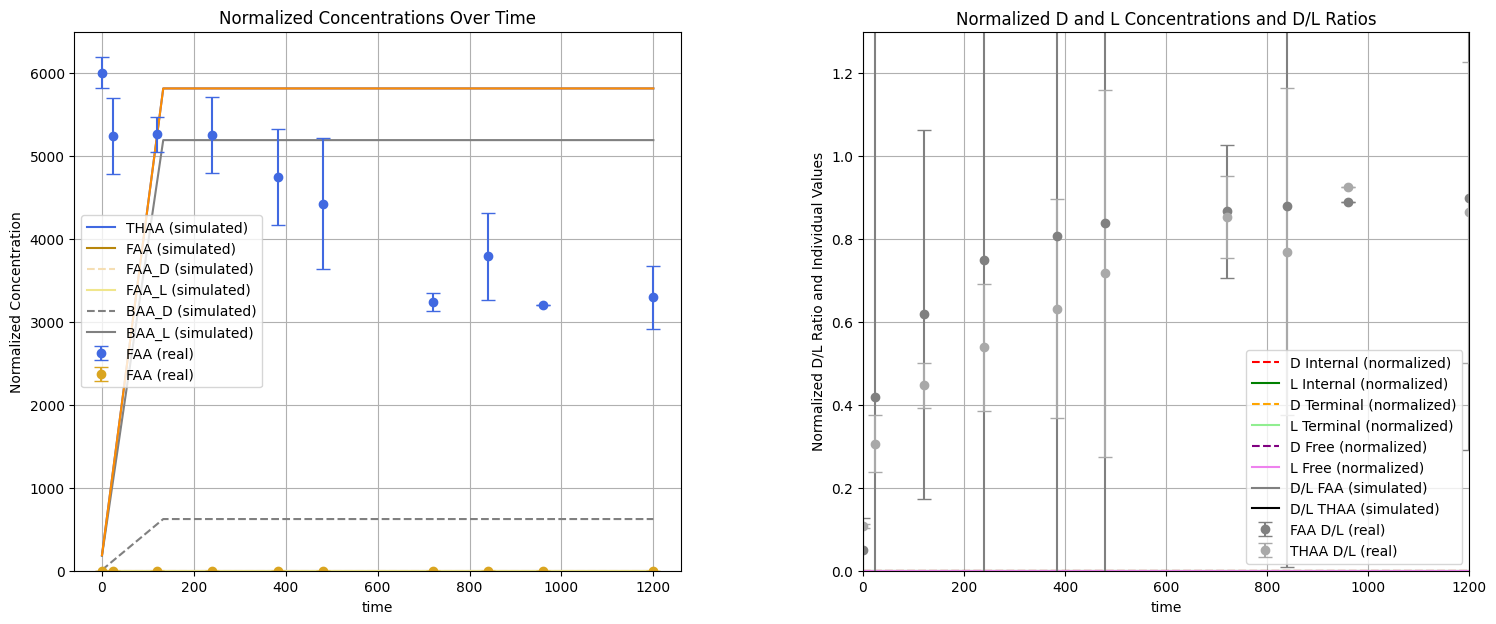

In [ ]:
#@title #model parameters

NUM_TIME_POINTS = 10  # Example value; adjust as necessary
#protein
initial_length = 1500  # Example initial protein length#@title  Function to simulate
fold_water = 8

user_defined_max_time = 1200  # Example of user-defined max_time


# Call the simulation function
simulation_results_df = simulate_amino_acid_hydrolysis(real_DL, amino_acid, initial_length, fold_water, rate_params,max_time=user_defined_max_time)

#save data
simulation_results_df.to_csv("simulation_results.csv", index=False)
logging.info("Simulation completed. Results saved to simulation_results.csv")

print(simulation_results_df.head())

# Plot results:
plot_simulation_results(simulation_results_df, real_DL, 'Asx')

# # Display the results
# print(results_df(10))

In [ ]:
# Print the contents of the log file
with open('/content/drive/MyDrive/Colab_Notebooks/AAR_Model/Fitting/Debugging/simulate_amino_acid_hydrolysis.log', 'r') as log_file:
    print(log_file.read())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab_Notebooks/AAR_Model/Fitting/Debugging/simulate_amino_acid_hydrolysis.log'

In [ ]:
def check_racemization(simulated_data, step):
    dl_ratio_term = simulated_data['D_term'][step] / simulated_data['L_term'][step] if simulated_data['L_term'][step] != 0 else float('inf')
    dl_ratio_free = simulated_data['D_free'][step] / simulated_data['L_free'][step] if simulated_data['L_free'][step] != 0 else float('inf')
    print(f"Step {step}: D/L ratio terminal = {dl_ratio_term:.4f}, D/L ratio free = {dl_ratio_free:.4f}")

def check_internal_terminal_balance(simulated_data, step):
    total_internal = simulated_data['D_int'][step] + simulated_data['L_int'][step]
    total_terminal = simulated_data['D_term'][step] + simulated_data['L_term'][step]
    print(f"Step {step}: Total internal = {total_internal:.2f}, Total terminal = {total_terminal:.2f}")

# Call these functions in your simulation loop
for i in range(1, num_time_points):
    # ... existing simulation code ...

    if i % 10 == 0:  # Check every 10th step
        check_racemization(simulated_data, i)
        check_internal_terminal_balance(simulated_data, i)

In [ ]:
#print(real_data.head(15))

In [ ]:
#@title #Optimise


# Define the objective function to optimize
def objective_function(params, real_data, amino_acid):
    # Unpack parameters
    (fixed_rate_internal, fixed_rate_terminal, fixed_rate_free, fold_water,
     slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size,
     slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate) = params

    # Fixed parameters for simulation
    fixed_rate_hydrolysis = 0.02
    fixed_rate_loss = 0.015
    initial_length = 1500

    # Simulate amino acid hydrolysis with these parameters
    simulated_data = simulate_amino_acid_hydrolysis(
        real_data, amino_acid, initial_length, fold_water, fixed_rate_hydrolysis, fixed_rate_loss,
        fixed_rate_internal, fixed_rate_terminal, fixed_rate_free, slow_hydrolysis_pool_size,
        slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate,
        slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)

    # Assume simulated_data is a dictionary with keys 'D_int', 'L_int', 'D_free', 'L_free', and 'time'
    simulated_THAA_DL = (simulated_data['D_free'] + simulated_data['D_int']) / \
                        (simulated_data['L_free'] + simulated_data['L_int'])
    simulated_FAA_DL = simulated_data['D_free'] / simulated_data['L_free']

    # Compute error between simulated and observed D/L ratios
    observed_THAA_DL = real_data[f'{amino_acid}_D/L_THAA_Mean']
    observed_FAA_DL = real_data[f'{amino_acid}_D/L_FAA_Mean']
    error_THAA_DL = np.sum((simulated_THAA_DL - observed_THAA_DL)**2)
    error_FAA_DL = np.sum((simulated_FAA_DL - observed_FAA_DL)**2)

    return error_THAA_DL + error_FAA_DL

# Define bounds for the optimization parameters
bounds = [
    (0, 1), (0, 1), (0, 1),
    (1, 10), (0, 1), (0, 0.001),
    (0, 1), (0, 0.001), (0, 1), (0, 0.001)
]

# Run optimization
result = differential_evolution(
    objective_function, bounds, args=(real_data, 'Val'),
    strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1.0), recombination=0.7)

# Print optimized parameters
print("Optimized parameters:")
param_names = ['fixed_rate_internal', 'fixed_rate_terminal', 'fixed_rate_free', 'fold_water',
               'slow_hydrolysis_pool_size', 'slow_hydrolysis_pool_relative_rate',
               'slow_DL_terminal_pool_size', 'slow_DL_terminal_pool_relative_rate',
               'slow_DL_internal_pool_size', 'slow_DL_internal_pool_relative_rate']
for name, value in zip(param_names, result.x):
    print(f"{name}: {value}")

print(f"Final optimization error: {result.fun}")


# Create a dictionary to store the optimized parameters
optimized_params = {}

# Store each parameter in the dictionary using descriptive keys
param_names = ['fixed_rate_internal', 'fixed_rate_terminal', 'fixed_rate_free', 'fold_water',
               'slow_hydrolysis_pool_size', 'slow_hydrolysis_pool_relative_rate',
               'slow_DL_terminal_pool_size', 'slow_DL_terminal_pool_relative_rate',
               'slow_DL_internal_pool_size', 'slow_DL_internal_pool_relative_rate']
for name, value in zip(param_names, result.x):
    optimized_params[name] = value

print(simulated_data.head(15))

print("Optimized parameters stored in dictionary:")
print(optimized_params)

plot_simulation_results(simulated_data, real_data, 'Val')

In [ ]:
# Dummy data
Asx_110_data = {
    'temp (°C)': [110.00] * 10,
    'time': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Asx_Conc_FAA_Mean': [0.03, 0.05, 0.13, 0.19, 0.24, 0.27, 0.25, 0.25, 0.27, 0.25],
    'Asx_Conc_FAA_Std': [0.02, 0.01, 0.01, 0.03, 0.03, 0.05, 0.01, 0.00, 0.00, 0.02],
    'Asx_D/L_FAA_Mean': [0.05, 0.42, 0.62, 0.75, 0.81, 0.84, 0.87, 0.88, 0.89, 0.90],
    'Asx_D/L_FAA_Std': [0.04, 0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.01, 0.00, 0.00],
    'Asx_Conc_THAA_Mean': [1.00, 0.87, 0.88, 0.88, 0.79, 0.74, 0.54, 0.63, 0.53, 0.55],
    'Asx_Conc_THAA_Std': [0.02, 0.10, 0.05, 0.10, 0.13, 0.17, 0.02, 0.12, 0.00, 0.08],
    'Asx_D/L_THAA_Mean': [0.12, 0.41, 0.62, 0.72, 0.78, 0.81, 0.85, 0.86, 0.82, 0.89],
    'Asx_D/L_THAA_Std': [0.00, 0.03, 0.04, 0.01, 0.02, 0.01, 0.00, 0.01, 0.00, 0.01]
}

Val_data = {
    'temp (°C)': [110.00] * 10,
    'time': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Val_Conc_FAA_Mean': [9.50, 43.43, 179.40, 328.40, 488.50, 593.43, 613.33, 647.00, 714.00, 709.00],
    'Val_Conc_FAA_Std': [3.54, 10.05, 14.08, 38.95, 60.04, 98.10, 21.50, 16.52, 0.00, 55.07],
    'Val_D/L_FAA_Mean': [0.00, 0.46, 0.32, 0.35, 0.39, 0.42, 0.49, 0.52, 0.54, 0.60],
    'Val_D/L_FAA_Std': [0.00, 0.25, 0.06, 0.04, 0.02, 0.03, 0.02, 0.03, 0.00, 0.01],
    'Val_Conc_THAA_Mean': [871.67, 2489.43, 2562.17, 2681.50, 2561.43, 2487.80, 2060.33, 2488.33, 2184.00, 2351.00],
    'Val_Conc_THAA_Std': [82.14, 282.91, 205.07, 300.85, 422.25, 433.43, 82.71, 496.51, 0.00, 345.33],
    'Val_D/L_THAA_Mean': [0.03, 0.05, 0.09, 0.14, 0.19, 0.23, 0.35, 0.37, 0.40, 0.51],
    'Val_D/L_THAA_Std': [0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.00, 0.02, 0.00, 0.04]
}

Phe_data = {
    'temp (°C)': [110.00] * 10,
    'time': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Phe_Conc_FAA_Mean': [12.00, 45.00, 180.00, 330.00, 490.00, 595.00, 610.00, 650.00, 715.00, 710.00],  # Hypothetical data
    'Phe_Conc_FAA_Std': [3.50, 10.00, 15.00, 40.00, 60.00, 95.00, 20.00, 15.00, 0.00, 55.00],  # Hypothetical data
    'Phe_D/L_FAA_Mean': [0.00, 0.47, 0.33, 0.36, 0.40, 0.43, 0.50, 0.53, 0.55, 0.61],  # Hypothetical data
    'Phe_D/L_FAA_Std': [0.00, 0.20, 0.05, 0.05, 0.02, 0.03, 0.02, 0.03, 0.00, 0.02],  # Hypothetical data
    'Phe_Conc_THAA_Mean': [870.00, 2490.00, 2560.00, 2680.00, 2560.00, 2480.00, 2060.00, 2490.00, 2180.00, 2350.00],  # Hypothetical data
    'Phe_Conc_THAA_Std': [80.00, 280.00, 200.00, 300.00, 420.00, 430.00, 80.00, 490.00, 0.00, 340.00],  # Hypothetical data
    'Phe_D/L_THAA_Mean': [0.02, 0.06, 0.08, 0.13, 0.18, 0.22, 0.34, 0.36, 0.39, 0.50],  # Hypothetical data
    'Phe_D/L_THAA_Std': [0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.00, 0.02, 0.00, 0.03]  # Hypothetical data
}


In [ ]:
def simulate_amino_acid_hydrolysis(data, amino_acid, initial_length, fold_water, fixed_rate_hydrolysis, fixed_rate_loss, fixed_rate_internal, fixed_rate_terminal, fixed_rate_free,
                                   slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate):
    """Simulate hydrolysis for a given amino acid over time using the updated polymer breakdown model."""
    # Extract specific amino acid data
    prefix = f'{amino_acid}_'
    thaa_col = f'{prefix}Conc_THAA_Mean'
    faa_col = f'{prefix}Conc_FAA_Mean'
    dl_thaa_col = f'{prefix}D/L_THAA_Mean'
    dl_faa_col = f'{prefix}D/L_FAA_Mean'

    max_time = data['time'].max()
    num_time_points = 100
    time_points = np.linspace(0, max_time, num_time_points)
    dt = time_points[1] - time_points[0]

    # Initial concentrations and water calculations
    initial_thaa = data[thaa_col].iloc[0]
    total_water = initial_thaa * fold_water
    residual_water = total_water

    # Parameters for the new model
    N = initial_length
    k = fixed_rate_hydrolysis
    concentration = initial_thaa
    fragments = [N]
    water_molecules = fold_water * (N - 1)

    # Initialize arrays for storing results
    simulated_data = {
        'time': time_points,
        'THAA': np.zeros(num_time_points),
        'FAA': np.zeros(num_time_points),
        'BAA': np.zeros(num_time_points),
        'Termini': np.zeros(num_time_points),
        'N_Termini': np.zeros(num_time_points),
        'Residual_water': np.zeros(num_time_points),
        'D_int': np.zeros(num_time_points),
        'L_int': np.zeros(num_time_points),
        'D_term': np.zeros(num_time_points),
        'L_term': np.zeros(num_time_points),
        'D_free': np.zeros(num_time_points),
        'L_free': np.zeros(num_time_points),
        'Water_used_hydrolysis': np.zeros(num_time_points),
        'Water_generated_decomposition': np.zeros(num_time_points)
    }

    # Set initial values
    simulated_data['THAA'][0] = initial_thaa
    simulated_data['FAA'][0] = data[faa_col].iloc[0]
    simulated_data['BAA'][0] = simulated_data['THAA'][0] - simulated_data['FAA'][0]
    simulated_data['Residual_water'][0] = residual_water

    # Initial D/L ratios
    DL_THAA = data[dl_thaa_col].iloc[0]
    DL_FAA = data[dl_faa_col].iloc[0]
    D_total, L_total = solve_dl(DL_THAA, simulated_data['THAA'][0])
    D_free, L_free = solve_dl(DL_FAA, simulated_data['FAA'][0])

    simulated_data['D_int'][0] = D_total - D_free
    simulated_data['L_int'][0] = L_total - L_free
    simulated_data['D_term'][0] = 0
    simulated_data['L_term'][0] = 0
    simulated_data['D_free'][0] = D_free
    simulated_data['L_free'][0] = L_free

    # Time loop for simulation
    for i in range(1, num_time_points):
        # New polymer breakdown model
        new_fragments = []
        for fragment_length in fragments:
            num_bonds = fragment_length - 1

            # Adjust k based on water availability
            if fold_water < 10:
                k_adjusted = k * (water_molecules / (fold_water * (N - 1)))
            else:
                k_adjusted = k

            # Calculate probability of each bond breaking (first-order kinetics)
            bond_break_probabilities = [min(k_adjusted * dt, 1) for _ in range(num_bonds)]

            # Randomly determine which bonds break
            broken_bonds = np.where(np.random.rand(num_bonds) < bond_break_probabilities)[0]

            # Update fragments and water molecules if bonds break
            if len(broken_bonds) > 0:
                water_molecules -= len(broken_bonds)  # Consume water molecules
                last_break = 0
                for break_point in broken_bonds:
                    new_fragments.append(break_point - last_break + 1)
                    last_break = break_point + 1
                new_fragments.append(fragment_length - last_break)
            else:
                new_fragments.append(fragment_length)        # Decay process
        free_amino_acids = (simulated_data['D_free'][i] + simulated_data['L_free'][i])
        decay_amount = free_amino_acids * fixed_rate_loss * dt
        simulated_data['Decayed_pool'][i] = max(simulated_data['Decayed_pool'][i-1] + decay_amount, 0)  # Ensure no negative values

        fragments = new_fragments

        # Update residue counts
        total_F = sum([1 for frag in fragments if frag == 1])
        total_T = sum([2 for frag in fragments if frag > 1])
        total_I = sum([frag - 2 for frag in fragments if frag > 2])

        # Update simulated data
        simulated_data['FAA'][i] = (total_F / N) * concentration
        simulated_data['Termini'][i] = (total_T / N) * concentration
        simulated_data['BAA'][i] = ((total_T + total_I) / N) * concentration
        simulated_data['THAA'][i] = simulated_data['FAA'][i] + simulated_data['BAA'][i]
        simulated_data['N_Termini'][i] = (len(fragments) / N) * concentration
        simulated_data['Residual_water'][i] = water_molecules

        # D/L ratio updates
        simulated_data['D_int'][i], simulated_data['L_int'][i] = update_dl_ratio(simulated_data['D_int'][i-1], simulated_data['L_int'][i-1], fixed_rate_internal, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)
        simulated_data['D_term'][i], simulated_data['L_term'][i] = update_dl_ratio(simulated_data['D_term'][i-1], simulated_data['L_term'][i-1], fixed_rate_terminal, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate)
        simulated_data['D_free'][i], simulated_data['L_free'][i] = update_dl_ratio(simulated_data['D_free'][i-1], simulated_data['L_free'][i-1], fixed_rate_free, 0, 1)

        # Water balance
        water_used = (simulated_data['THAA'][i-1] - simulated_data['THAA'][i]) * fold_water
        simulated_data['Water_used_hydrolysis'][i] = simulated_data['Water_used_hydrolysis'][i-1] + water_used

        # Ensure mass balance
        total_amino_acids = simulated_data['D_int'][i] + simulated_data['L_int'][i] + simulated_data['D_term'][i] + simulated_data['L_term'][i] + simulated_data['D_free'][i] + simulated_data['L_free'][i]
        if abs(total_amino_acids - simulated_data['THAA'][i]) > 1e-6:
            print(f"Warning: Mass balance issue at step {i}")

    # Optional: Print every 10th step
    print_flag = True  # Flag to track initial step (0)

    for i in range(len(simulated_data['THAA'])):  # Assuming THAA represents your data
        data_list = [f"THAA={simulated_data['THAA'][i]:.2f}",
                    f"FAA={simulated_data['FAA'][i]:.2f}",
                    # ... other data definitions ... (replace with your actual data)
                    f"Difference={abs(total_amino_acids - simulated_data['THAA'][i]):.2f}"]

        if (i % 10 == 0 or print_flag):
            print(f"Step {i}: " + ', '.join(data_list))
        print_flag = False  # Reset flag after first iteration

    # Create a DataFrame after printing:
    simulated_data_df = pd.DataFrame(simulated_data)  # Create DataFrame from simulated_data


    return pd.DataFrame(simulated_data)